In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

In [2]:
# IMPORTANT: SET RANDOM SEEDS FOR REPRODUCIBILITY
import os
os.environ['PYTHONHASHSEED'] = str(420)
import random
random.seed(420)
np.random.seed(420)
tf.random.set_seed(420)

In [4]:
# Load and split data
import shap
X_train, X_test, Y_train, Y_test = train_test_split(
    *shap.datasets.adult(), test_size=0.2, random_state=7)
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train, Y_train, test_size=0.2, random_state=0)

# Data scaling
num_features = X_train.shape[1]
num_classes = 2
feature_names = X_train.columns.tolist()
ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train.values)
X_val = ss.transform(X_val.values)
X_test = ss.transform(X_test.values)

# Train Model

In [5]:
import pickle
import lightgbm as lgb

### Save Dir

In [6]:
model_dir = os.path.join(os.getcwd(), 'census_models')
if not os.path.isdir(model_dir):
    os.makedirs(model_dir)

In [7]:
if os.path.isfile(os.path.join(model_dir, 'census model.pkl')):
    print('Loading saved model')
    with open(os.path.join(model_dir, 'census model.pkl'), 'rb') as f:
        model = pickle.load(f)

else:
    #Setup
    params = {
        "max_bin": 512,
        "learning_rate": 0.05,
        "boosting_type": "gbdt",
        "num_class": 2,
        "objective": "multiclass",
        "metric": "multi_logloss",
        "num_leaves": 10,
        "verbose": -1,
        "min_data": 100,
        "boost_from_average": True
    }

    # More setup
    d_train = lgb.Dataset(X_train, label=Y_train)
    d_val = lgb.Dataset(X_val, label=Y_val)

    # Train model
    model = lgb.train(params, d_train, 10000, valid_sets=[d_val],
                      early_stopping_rounds=50, verbose_eval=1000)

    # Save model
    with open(os.path.join(model_dir, 'census model.pkl'), 'wb') as f:
        pickle.dump(model, f)

Loading saved model


# Train Surrogate

In [8]:
from fastshap import Surrogate

### Surrogate Model

In [9]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model, Sequential

model_input = Input(shape=num_features, name='input')
net = Dense(128, activation="relu")(model_input)
net = Dense(128, activation="relu")(net)
out = Dense(num_classes, activation="softmax")(net)

surrogate_model = Model(model_input, out)

### Train

In [11]:
if os.path.isfile(os.path.join(model_dir, 'surrogate.h5')):
    print('Loading saved model')
    surrogate_model = tf.keras.models.load_model(os.path.join(model_dir, 'surrogate.h5'))
    
    surrogate = Surrogate(surrogate_model = surrogate_model,  
                          num_features = num_features,
                          baseline = 0)
else:
    surrogate = Surrogate(surrogate_model = surrogate_model,  
                          num_features = num_features,
                          baseline = 0)

    surrogate.train(original_model = model,
                    train_data = X_train,
                    val_data = X_val,
                    batch_size = 64,
                    max_epochs = 100,
                    validation_batch_size = 10000,
                    loss_fn="categorical_crossentropy",
                    lr=1e-3,
                    min_lr=1e-5,
                    lr_factor=0.9,
                    lookback=10,
                    verbose=1, 
                    model_dir = model_dir)

Loading saved model


# Train FastSHAP

In [12]:
from fastshap import FastSHAP

### Explainer Model

In [13]:
model_input = Input(shape=num_features, name='input')
net = Dense(128, activation="relu")(model_input)
net = Dense(128, activation="relu")(net)
out = Dense(num_classes * num_features, activation="linear")(net)

explainer = Model(model_input, out)

### Train

In [16]:
if os.path.isfile(os.path.join(model_dir, 'explainer.h5')):
    print('Loading saved model')
    explainer = tf.keras.models.load_model(os.path.join(model_dir, 'explainer.h5'))
    
    fastshap = FastSHAP(explainer, surrogate, 
                        normalization='additive',
                        link='identity')
else:    
    # Set up FastSHAP object
    fastshap = FastSHAP(explainer, surrogate, 
                        normalization='additive',
                        link='identity')

    # Train
    fastshap.train(train_data = X_train,
                   val_data = X_val,
                   batch_size=32,
                   validation_batch_size = 64,
                   num_samples=8,
                   max_epochs=200,
                   model_dir = model_dir, 
                   lr=2e-4,
                   verbose = 1, 
                   lookback = 5)

Loading saved model


# Compare with KernelSHAP

In [17]:
import matplotlib.pyplot as plt
import shapreg  # https://github.com/iancovert/shapley-regression

In [18]:
# Setup for KernelSHAP
from tensorflow.keras.layers import Multiply
def imputer(x, S):
    S = tf.constant(S, dtype=tf.float32)
    xs = Multiply()([x, S])
    pred = surrogate.surrogate_model(xs)
    return pred.numpy()

In [19]:
# Select example
ind = np.random.choice(len(X_test))
x = X_test[ind:ind+1]
y = int(Y_test[ind])

# Run FastSHAP
fastshap_values = fastshap.shap_values(x)[0].transpose(1,0)

# Run KernelSHAP to convergence
game = shapreg.games.PredictionGame(imputer, x)
shap_values, all_results = shapreg.shapley.ShapleyRegression(
    game, batch_size=32, paired_sampling=False, detect_convergence=True,
    bar=True, return_all=True)

  0%|          | 0/1 [00:00<?, ?it/s]

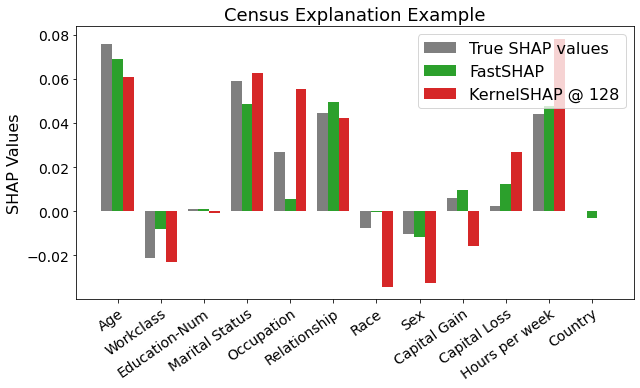

In [20]:
# Create figure
plt.figure(figsize=(9, 5.5))

# Bar chart
width = 0.75
kernelshap_iters = 128
plt.bar(np.arange(num_features) - width / 3, shap_values.values[:, y],
        width / 3, label='True SHAP values', color='tab:gray')
plt.bar(np.arange(num_features), fastshap_values[:, y],
        width / 3, label='FastSHAP', color='tab:green')
plt.bar(np.arange(num_features) + width / 3,
        all_results['values'][list(all_results['iters']).index(kernelshap_iters)][:, y],
        width / 3, label='KernelSHAP @ {}'.format(kernelshap_iters), color='tab:red')

# Annotations
plt.legend(fontsize=16)
plt.tick_params(labelsize=14)
plt.ylabel('SHAP Values', fontsize=16)
plt.title('Census Explanation Example', fontsize=18)
plt.xticks(np.arange(num_features), feature_names,
           rotation=35, rotation_mode='anchor', ha='right')

plt.tight_layout()
plt.show()